In [1]:
#SELECTION DEFINITION

THE_BIG_SELECTION = (
    "((Dst_M - D0_M) > 143) & ((Dst_M - D0_M) < 148) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 1.7) & (pi_TRACK_CHI2NDOF < 1.7) & "
    "(K_PT > 250) & (pi_PT > 250) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(mp_TRACK_CHI2NDOF < 2) & "
    "(mm_TRACK_CHI2NDOF < 2) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 700) & (mm_PT > 700) & "
    "(mp_IPCHI2_OWNPV > 2) & (mm_IPCHI2_OWNPV > 2) & "
    "(Jpsi_M < 3140) & (Jpsi_M > 3040) & "
    "(pi_soft_PT > 250) & "
    "(Bc_ENDVERTEX_CHI2 < 4.2) & "
    "(Bc_IPCHI2_OWNPV < 10) & "
    "(Bc_DIRA_OWNPV > 0.99)"
)


In [2]:
#IMPORTING LIBRARIES
import uproot
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier, callback, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pickle
from datetime import datetime
import optuna
import joblib
from sklearn.datasets import make_classification
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
import pickle


/Users/khrystina/new_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#DATA DOWNLOADING
files_simu = [
    './simulation/2011_MagDown.root', 
    './simulation/2015_MagDown.root',
    './simulation/2015_MagUp.root',
    './simulation/2016_MagDown.root',
    './simulation/2016_MagUp.root',
    './simulation/2017_MagDown.root',
    './simulation/2017_MagUp.root',
    './simulation/2018_MagDown.root',
    './simulation/2018_MagUp.root'
]

files_real_data = [
    './real_data/2011_MagDown.root', 
    './real_data/2011_MagUp.root',
    './real_data/2012_MagDown.root', 
    './real_data/2012_MagUp.root',
    './real_data/2015_MagDown.root', 
    './real_data/2015_MagUp.root',
    './real_data/2016_MagDown.root', 
    './real_data/2016_MagUp.root',
    './real_data/2017_MagDown.root', 
    './real_data/2017_MagUp.root',
    './real_data/2018_MagDown.root', 
    './real_data/2018_MagUp.root'
]
simu_data = uproot.concatenate(files_simu, cut = f"{THE_BIG_SELECTION} & (Bc_BKGCAT == 0)", library='pd')
real_data = uproot.concatenate(files_real_data, cut = f"{THE_BIG_SELECTION} & ((Bc_FullDTF_M < 6250.) | (Bc_FullDTF_M > 6300.))", library='pd')
real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3131/2903014781.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3131/2903014781.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


In [4]:
#DEFINING TRAINING FEATURES

feature_columns = [

    'mp_PT',
    'mm_PT',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',

    'Bc_FD_OWNPV',
    'Jpsi_FD_ORIVX',
    'D0_FD_ORIVX'
    ]

In [5]:
#PREPARING DATASET
# Separate features and labels
X_simu = simu_data[feature_columns]
y_simu = np.ones(len(simu_data))  # Label: 1 for simulation data

X_real = real_data[feature_columns]
y_real = np.zeros(len(real_data))  # Label: 0 for real data

# Combine features and labels
X_all = pd.concat([X_simu, X_real], ignore_index=True)
y_all = np.concatenate([y_simu, y_real]) 

print(f"SIMULATION set size: {X_simu.shape}")
print(f"REAL DATA set size: {X_real.shape}")


SIMULATION set size: (28209, 7)
REAL DATA set size: (2594, 7)


In [6]:
#TIME FUNCTION

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    else:
        elapsed_time = datetime.now() - start_time
        thour, temp_sec = divmod(elapsed_time.total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %d hours, %d minutes, and %.2f seconds.' % (int(thour), int(tmin), tsec))


In [7]:
#IMPLEMENTING OPTUNA TO FIND THE BEST MODEL

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=76)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)


print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 20)
    }
    model_optuna = XGBClassifier(**params, random_state=52, eval_metric="logloss")
    model_optuna.fit(X_train, y_train)
    preds = model_optuna.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, preds)
    if not hasattr(objective, 'best_score') or score > objective.best_score:
        objective.best_score = score
        objective.best_model = model_optuna 
    return score

# Optimize
study = optuna.create_study(direction="maximize")
start_time = timer(None)
study.optimize(objective, n_trials=400)
best_model = objective.best_model
joblib.dump(best_model, "best_optuna_model.pkl")
timer(start_time)

print("Best parameters:", study.best_params)
print("Best ROC-AUC Score:", study.best_value)
print("Best model saved as 'best_optuna_model.pkl'")


[I 2025-02-06 16:53:04,141] A new study created in memory with name: no-name-60cf07ad-9c2e-489b-8875-921414d7d740


Training set size: (24642, 7)
Test set size: (6161, 7)


[I 2025-02-06 16:53:06,490] Trial 0 finished with value: 0.8853909876991228 and parameters: {'n_estimators': 492, 'learning_rate': 0.2278858804407203, 'max_depth': 18}. Best is trial 0 with value: 0.8853909876991228.
[I 2025-02-06 16:53:07,439] Trial 1 finished with value: 0.8840506411833979 and parameters: {'n_estimators': 365, 'learning_rate': 0.19882646872951162, 'max_depth': 7}. Best is trial 0 with value: 0.8853909876991228.
[I 2025-02-06 16:53:09,123] Trial 2 finished with value: 0.883197630200621 and parameters: {'n_estimators': 393, 'learning_rate': 0.19173407205374046, 'max_depth': 13}. Best is trial 0 with value: 0.8853909876991228.
[I 2025-02-06 16:53:10,301] Trial 3 finished with value: 0.8989218483434067 and parameters: {'n_estimators': 278, 'learning_rate': 0.02245608095374981, 'max_depth': 9}. Best is trial 3 with value: 0.8989218483434067.
[I 2025-02-06 16:53:11,766] Trial 4 finished with value: 0.8924437965176019 and parameters: {'n_estimators': 244, 'learning_rate': 0


 Time taken: 0 hours, 2 minutes, and 37.83 seconds.
Best parameters: {'n_estimators': 233, 'learning_rate': 0.057345347578566394, 'max_depth': 3}
Best ROC-AUC Score: 0.9096708642871345
Best model saved as 'best_optuna_model.pkl'


In [8]:
#TRAINING MODEL WITH K-FOLD AND EARLY STOPPING
from sklearn.preprocessing import LabelEncoder
n_folds = 5
fold_accuracies = []

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=11)

# Load Optuna-saved model parameters
with open("best_optuna_model.pkl", "rb") as file:
    best_model_params = pickle.load(file)
try:
    print(type(best_model_params))  # Debugging step
    print(best_model_params) 
    if isinstance(best_model_params, XGBClassifier):
        best_model_params = best_model_params.get_params()  # Extract parameters from model
    elif not isinstance(best_model_params, dict):
        raise TypeError(f"Unexpected type for best_model_params: {type(best_model_params)}")

    elif not isinstance(best_model_params, dict):
        raise TypeError("Unexpected type for best_model_params:", type(best_model_params))


except ImportError as e:
    print("ImportError occurred:", e)

# Ensure parameters are valid for XGBClassifier
if hasattr(best_model_params, 'get_params'):
    best_model_params = best_model_params.get_params()


best_model_params.update({
    'random_state': 51, 
    'eval_metric': 'logloss' ,
    'early_stopping_rounds': 20 
})

classif_list = []
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}/{n_folds}...")
    # Initialize the model with the best parameters
    model_es = XGBClassifier(**best_model_params)
    # Split the data using iloc for pandas DataFrame compatibility
    X_train, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    

    # Fit the model with early stopping
    model_es.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    classif_list.append(model_es)
    # Evaluate the model on the validation set
    y_pred = model_es.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

mean_accuracy = np.mean(fold_accuracies)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}")

model_es.save_model("best_kfold_early_stopping_model.json")


<class 'xgboost.sklearn.XGBClassifier'>
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.057345347578566394, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=233, n_jobs=None,
              num_parallel_tree=None, random_state=52, ...)
Processing Fold 1/5...
Fold 1 Accuracy: 0.9456
Processing Fold 2/5...
Fold 2 Accuracy: 0.9403
Processing Fold 3/5...
Fold 3 Accuracy: 0.9408
Processing Fold 4/5...
Fold 4 Ac

In [177]:
#ACCURACY

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=92)

# Predict on the test set
y_pred = classif_list[1].predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.53      0.65       761
         1.0       0.94      0.99      0.96      5696

    accuracy                           0.93      6457
   macro avg       0.88      0.76      0.81      6457
weighted avg       0.93      0.93      0.93      6457



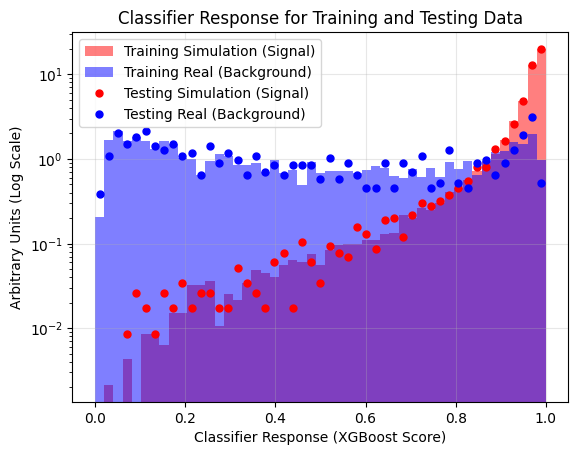

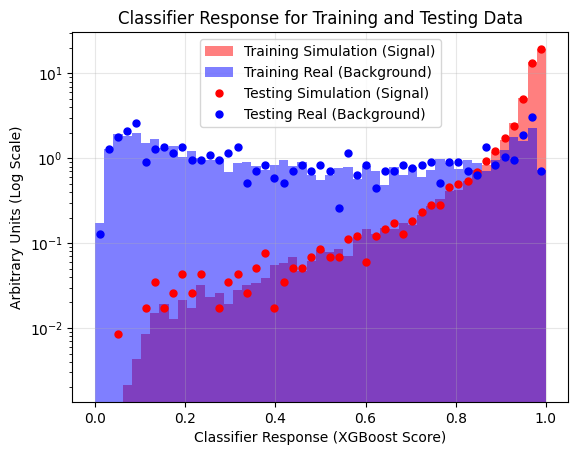

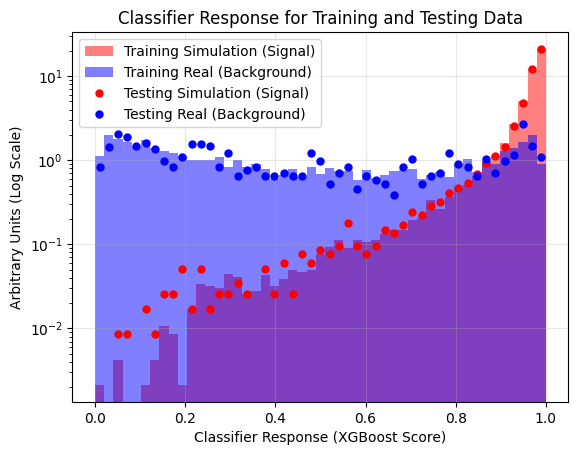

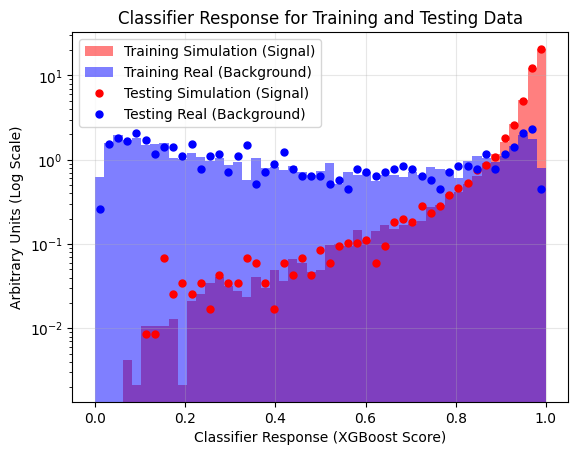

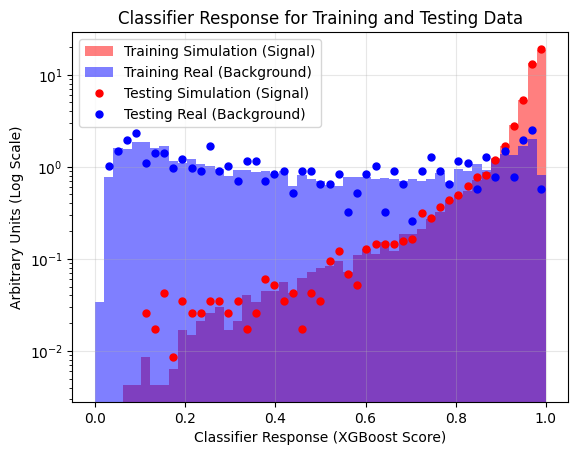

In [178]:
numb_of_classif = 5

for i in range (numb_of_classif):

    # Combine signal and background predictions for each set
    train_sim_signal = classif_list[i].predict_proba(X_train[y_train == 1])[:, 1]
    train_real_background = classif_list[i].predict_proba(X_train[y_train == 0])[:, 1]
    test_sim_signal = classif_list[i].predict_proba(X_test[y_test == 1])[:, 1]
    test_real_background = classif_list[i].predict_proba(X_test[y_test == 0])[:, 1]

    # Define bins for histograms
    bins = np.linspace(0, 1, 50)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Histograms for training data
    train_sim_hist, _ = np.histogram(train_sim_signal, bins=bins, density=True)
    train_real_hist, _ = np.histogram(train_real_background, bins=bins, density=True)

    # Histograms for test data (used for alignment)
    test_sim_hist, _ = np.histogram(test_sim_signal, bins=bins, density=True)
    test_real_hist, _ = np.histogram(test_real_background, bins=bins, density=True)

    # Plot histograms for training data
    plt.hist(train_sim_signal, bins=bins, alpha=0.5, label="Training Simulation (Signal)", color="red", density=True, histtype="stepfilled")
    plt.hist(train_real_background, bins=bins, alpha=0.5, label="Training Real (Background)", color="blue", density=True, histtype="stepfilled")

    # Plot test data as dots
    plt.plot(bin_centers, test_sim_hist, 'o', label="Testing Simulation (Signal)", color="red", markersize=5)
    plt.plot(bin_centers, test_real_hist, 'o', label="Testing Real (Background)", color="blue", markersize=5)

    # Labels, legend, and title
    plt.xlabel("Classifier Response (XGBoost Score)")
    plt.ylabel("Arbitrary Units (Log Scale)")
    plt.title("Classifier Response for Training and Testing Data")
    plt.legend()
    plt.yscale("log")  # Logarithmic scale for better visualization
    plt.grid(alpha=0.3)

    plt.show()


Optimal Threshold for Classifier 1: 0.5093932151794434


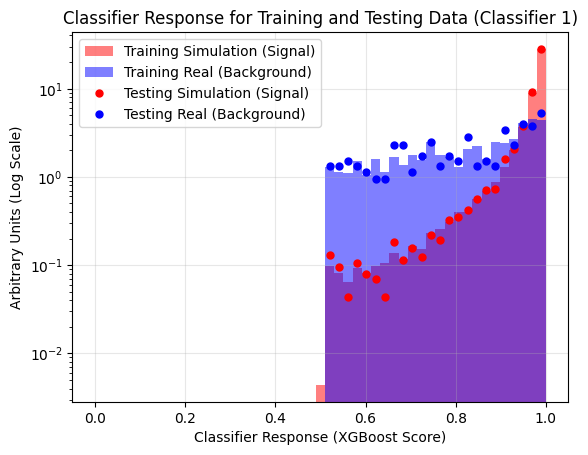

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.46      0.58       509
         1.0       0.95      0.99      0.97      5652

    accuracy                           0.95      6161
   macro avg       0.87      0.73      0.78      6161
weighted avg       0.94      0.95      0.94      6161

Optimal Threshold for Classifier 2: 0.4533419609069824


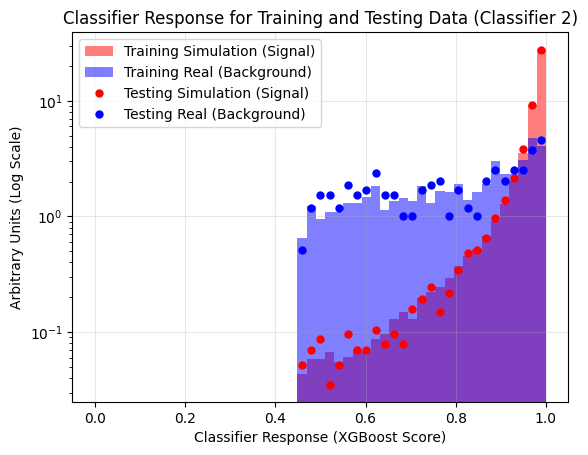

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.46      0.58       509
         1.0       0.95      0.99      0.97      5652

    accuracy                           0.95      6161
   macro avg       0.87      0.73      0.78      6161
weighted avg       0.94      0.95      0.94      6161

Optimal Threshold for Classifier 3: 0.5543869733810425


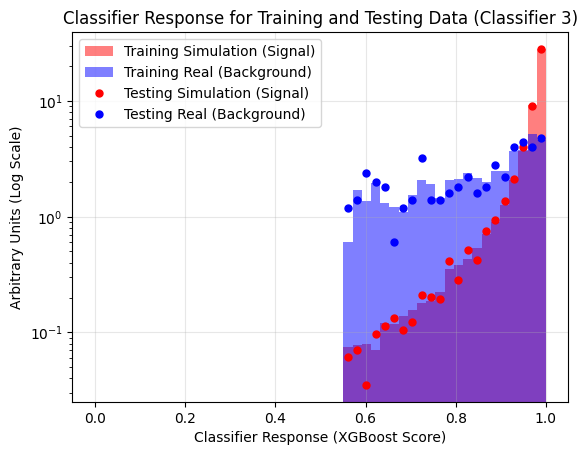

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.46      0.58       509
         1.0       0.95      0.99      0.97      5652

    accuracy                           0.95      6161
   macro avg       0.87      0.73      0.78      6161
weighted avg       0.94      0.95      0.94      6161

Optimal Threshold for Classifier 4: 0.5332655310630798


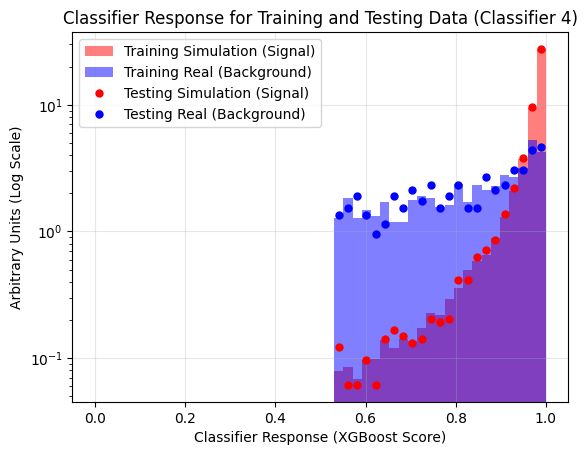

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.46      0.58       509
         1.0       0.95      0.99      0.97      5652

    accuracy                           0.95      6161
   macro avg       0.87      0.73      0.78      6161
weighted avg       0.94      0.95      0.94      6161

Optimal Threshold for Classifier 5: 0.5031783580780029


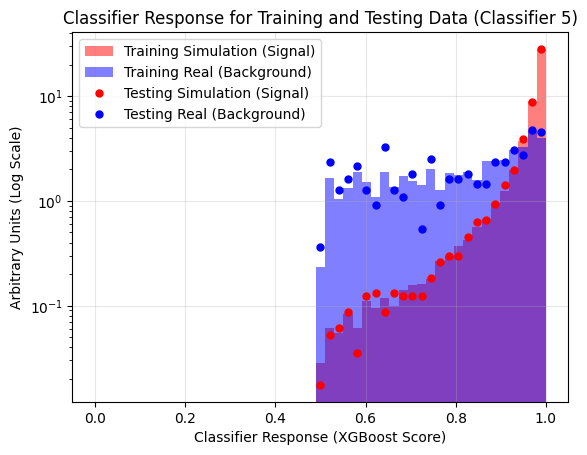

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.46      0.58       509
         1.0       0.95      0.99      0.97      5652

    accuracy                           0.95      6161
   macro avg       0.87      0.73      0.78      6161
weighted avg       0.94      0.95      0.94      6161



In [9]:
import numpy as np
from sklearn.metrics import precision_recall_curve

numb_of_classif = 5

for i in range(numb_of_classif):

    # Combine signal and background predictions for each set
    train_sim_signal = classif_list[i].predict_proba(X_train[y_train == 1])[:, 1]
    train_real_background = classif_list[i].predict_proba(X_train[y_train == 0])[:, 1]
    test_sim_signal = classif_list[i].predict_proba(X_test[y_test == 1])[:, 1]
    test_real_background = classif_list[i].predict_proba(X_test[y_test == 0])[:, 1]

    # Define a function to calculate the optimal threshold
    def find_optimal_threshold(y_true, y_scores):
        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
        
        # Maximize F1 score (where precision and recall are balanced)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        
        # Find the threshold that maximizes the F1 score
        optimal_threshold = thresholds[np.argmax(f1_scores)]
        return optimal_threshold

    # Find optimal threshold based on training data
    optimal_threshold = find_optimal_threshold(y_train, classif_list[i].predict_proba(X_train)[:, 1])
    print(f"Optimal Threshold for Classifier {i+1}: {optimal_threshold}")

    # Apply the threshold to filter the training and test sets
    train_sim_signal_filtered = train_sim_signal[train_sim_signal > optimal_threshold]
    train_real_background_filtered = train_real_background[train_real_background > optimal_threshold]
    test_sim_signal_filtered = test_sim_signal[test_sim_signal > optimal_threshold]
    test_real_background_filtered = test_real_background[test_real_background > optimal_threshold]

    # Define bins for histograms
    bins = np.linspace(0, 1, 50)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Histograms for training data (after applying threshold)
    train_sim_hist, _ = np.histogram(train_sim_signal_filtered, bins=bins, density=True)
    train_real_hist, _ = np.histogram(train_real_background_filtered, bins=bins, density=True)

    # Histograms for test data (used for alignment)
    test_sim_hist, _ = np.histogram(test_sim_signal_filtered, bins=bins, density=True)
    test_real_hist, _ = np.histogram(test_real_background_filtered, bins=bins, density=True)

    # Plot histograms for training data
    plt.hist(train_sim_signal_filtered, bins=bins, alpha=0.5, label="Training Simulation (Signal)", color="red", density=True, histtype="stepfilled")
    plt.hist(train_real_background_filtered, bins=bins, alpha=0.5, label="Training Real (Background)", color="blue", density=True, histtype="stepfilled")

    # Plot test data as dots
    plt.plot(bin_centers, test_sim_hist, 'o', label="Testing Simulation (Signal)", color="red", markersize=5)
    plt.plot(bin_centers, test_real_hist, 'o', label="Testing Real (Background)", color="blue", markersize=5)

    # Labels, legend, and title
    plt.xlabel("Classifier Response (XGBoost Score)")
    plt.ylabel("Arbitrary Units (Log Scale)")
    plt.title(f"Classifier Response for Training and Testing Data (Classifier {i+1})")
    plt.legend()
    plt.yscale("log")  # Logarithmic scale for better visualization
    plt.grid(alpha=0.3)

    # Show the plot for this classifier
    plt.show()
    y_pred = classif_list[1].predict(X_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Optimal Threshold for Classifier 5: 0.8
Accuracy for Classifier 5: 0.97
Classification Report for Classifier 5:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       165
         1.0       0.97      1.00      0.98      5339

    accuracy                           0.97      5504
   macro avg       0.49      0.50      0.49      5504
weighted avg       0.94      0.97      0.96      5504



/Users/khrystina/new_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/khrystina/new_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/khrystina/new_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


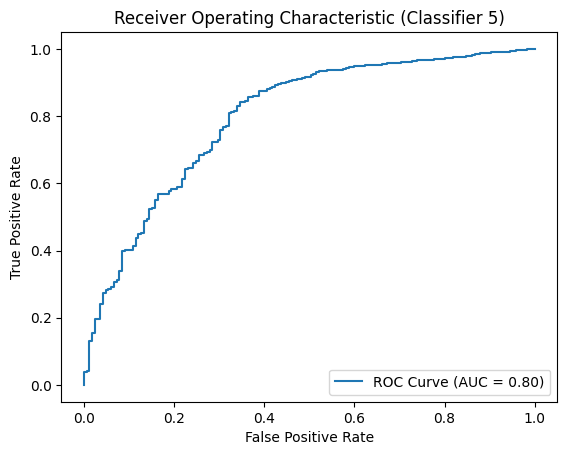

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Combine signal and background predictions for each set


optimal_threshold = 0.8

signal_probabilities = classif_list[i].predict_proba(X_all)[:, 1]
X_filtered = X_all[signal_probabilities > optimal_threshold]
y_filtered = y_all[signal_probabilities > optimal_threshold]
print(f"Optimal Threshold for Classifier {i+1}: {optimal_threshold}")

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=92)
train_sim_signal = classif_list[i].predict_proba(X_train[y_train == 1])[:, 1]
train_real_background = classif_list[i].predict_proba(X_train[y_train == 0])[:, 1]
test_sim_signal = classif_list[i].predict_proba(X_test[y_test == 1])[:, 1]
test_real_background = classif_list[i].predict_proba(X_test[y_test == 0])[:, 1]

# Predict using the current classifier (without threshold)
y_pred = classif_list[i].predict(X_test)

# Calculate accuracy using thresholded predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Classifier {i+1}: {accuracy:.2f}")

# Generate a classification report using thresholded predictions
print(f"Classification Report for Classifier {i+1}:")
print(classification_report(y_test, y_pred))

# Precision-Recall Curve using probabilities
precision, recall, thresholds = precision_recall_curve(y_test, classif_list[i].predict_proba(X_test)[:, 1])

# ROC Curve using probabilities
y_prob = classif_list[i].predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Apply threshold to predictions for ROC curve (thresholding affects the classification)
y_pred_thresholded = (y_prob > optimal_threshold).astype(int)

# Plot ROC curve with threshold
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Classifier {i+1})')
plt.legend(loc="lower right")
plt.show()


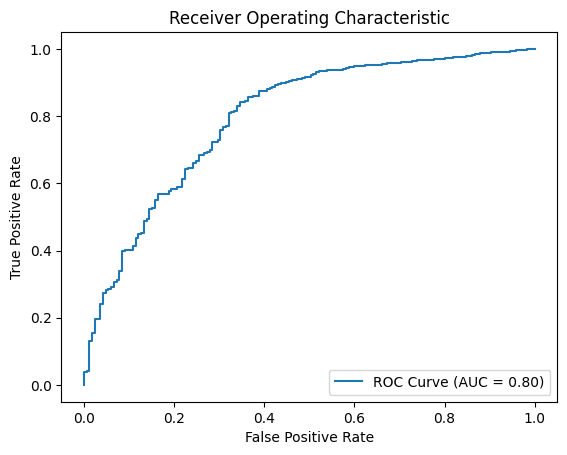

In [11]:

y_prob = model_es.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


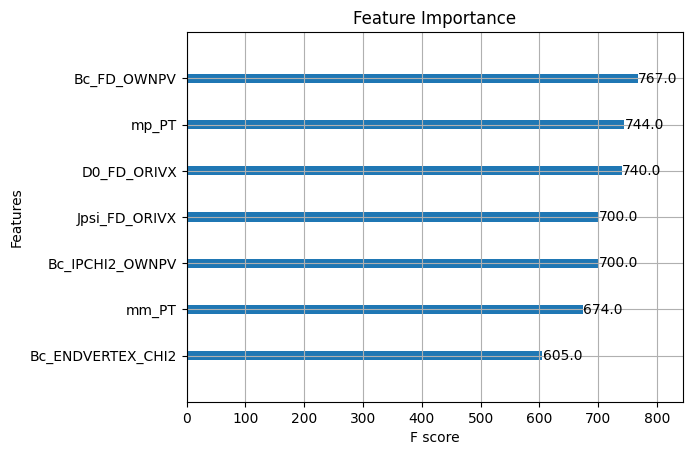

In [182]:

# Plot feature importance
plot_importance(model_es, importance_type='weight')
plt.title("Feature Importance")
plt.show()


Not-filtered data size: 2594
Filtered data size: 752


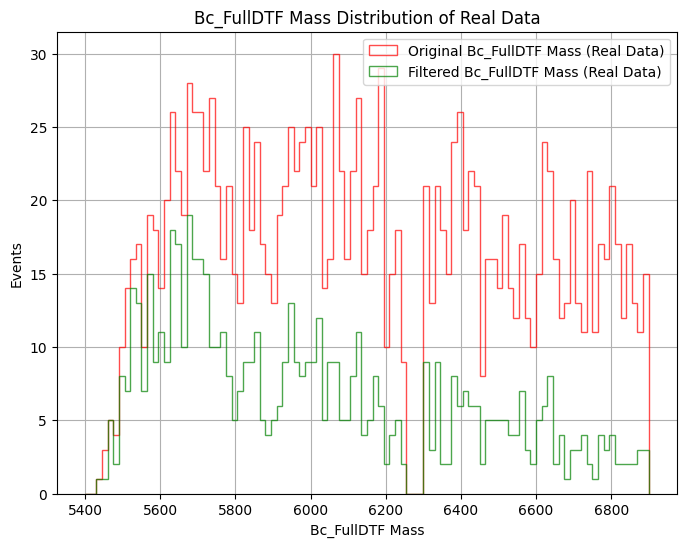

In [12]:
import numpy as np
import matplotlib.pyplot as plt

real_data_predictions = classif_list[i].predict_proba(X_real)[:, 1]
real_data_filtered = real_data[real_data_predictions > 0.8]

print(f"Not-filtered data size: {real_data.shape[0]}")
print(f"Filtered data size: {real_data_filtered.shape[0]}")

# --- Signal Shape in Range 6200-6350 from Simulation Data ---
signal_range = (simu_data['Bc_FullDTF_M'] > 6250) & (simu_data['Bc_FullDTF_M'] < 6300)
simu_signal_in_range = simu_data['Bc_FullDTF_M'][signal_range]

# Randomly sample 15 events from the simulation data in the range 6200-6350
simu_signal_sampled = np.random.choice(simu_signal_in_range, size=15, replace=False)

# --- Plot everything as histograms ---
plt.figure(figsize=(8, 6))


plt.hist(real_data['Bc_FullDTF_M'], range = (5400, 6900), bins=100, alpha=0.7, color='red', label="Original Bc_FullDTF Mass (Real Data)", histtype='step')
plt.hist(real_data_filtered['Bc_FullDTF_M'], range = (5400, 6900), bins=100, alpha=0.7, color='green', label="Filtered Bc_FullDTF Mass (Real Data)", histtype='step')
# Plot simulation signal in Bc_FullDTF Mass range (6200-6350) as a histogram
# plt.hist(simu_signal_in_range, bins=100, alpha=0.7, color='purple', label="Simulation Signal (6200-6350 range, 15 events)", histtype='step')

# Labels, legend, and title
plt.xlabel("Bc_FullDTF Mass")
plt.ylabel("Events")
plt.title("Bc_FullDTF Mass Distribution of Real Data")
plt.legend()
plt.grid(True)
plt.show()

Not-filtered data size: 3620
Filtered data size: 880


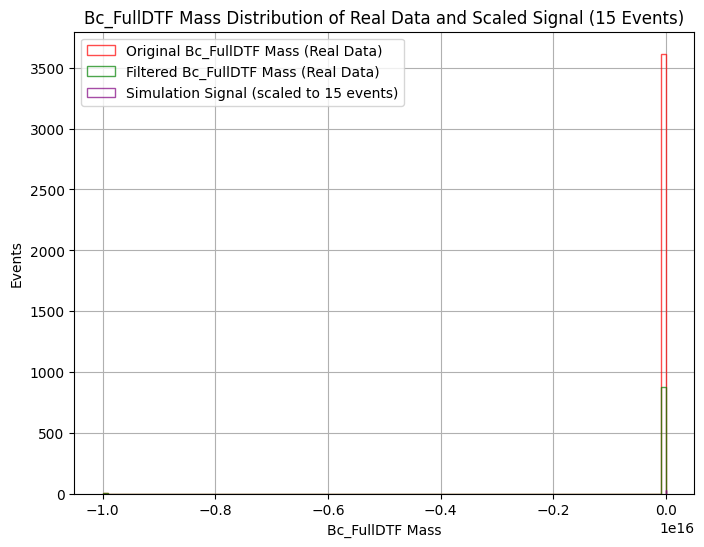

In [185]:
import numpy as np
import matplotlib.pyplot as plt

real_data_predictions = classif_list[i].predict_proba(X_real)[:, 1]
real_data_filtered = real_data[real_data_predictions > 0.8]

print(f"Not-filtered data size: {real_data.shape[0]}")
print(f"Filtered data size: {real_data_filtered.shape[0]}")

# --- Signal Shape in Range 6200-6350 from Simulation Data ---
signal_range = (simu_data['Bc_FullDTF_M'] > 6250) & (simu_data['Bc_FullDTF_M'] < 6300)
simu_signal_in_range = simu_data['Bc_FullDTF_M'][signal_range]

# --- Calculate Scaling Factor ---
total_sim_events = len(simu_data)  # Total number of events in the simulation
expected_signal_events = 15  # The number of events you want to see in the histogram

# Scaling factor to adjust the signal to the expected number of events
scaling_factor = expected_signal_events / total_sim_events

# --- Plot everything as histograms ---
plt.figure(figsize=(8, 6))

# Plot all Bc_FullDTF Mass (real data, not filtered) as a histogram
plt.hist(real_data['Bc_FullDTF_M'], bins=100, alpha=0.7, color='red', label="Original Bc_FullDTF Mass (Real Data)", histtype='step')

# Plot filtered Bc_FullDTF Mass (real data, filtered by classifier threshold) as a histogram
plt.hist(real_data_filtered['Bc_FullDTF_M'], bins=100, alpha=0.7, color='green', label="Filtered Bc_FullDTF Mass (Real Data)", histtype='step')

# Plot simulation signal in Bc_FullDTF Mass range (6200-6350) as a histogram
# Apply the scaling factor to the simulation signal histogram
plt.hist(simu_signal_in_range, bins=100, alpha=0.7, color='purple', label="Simulation Signal (scaled to 15 events)", 
         histtype='step', weights=((np.ones_like(simu_signal_in_range) * scaling_factor)+0.03))

# Labels, legend, and title
plt.xlabel("Bc_FullDTF Mass")
plt.ylabel("Events")
plt.title("Bc_FullDTF Mass Distribution of Real Data and Scaled Signal (15 Events)")
plt.legend()
plt.grid(True)
plt.show()


Not-filtered data size: 2594
Filtered data size: 752


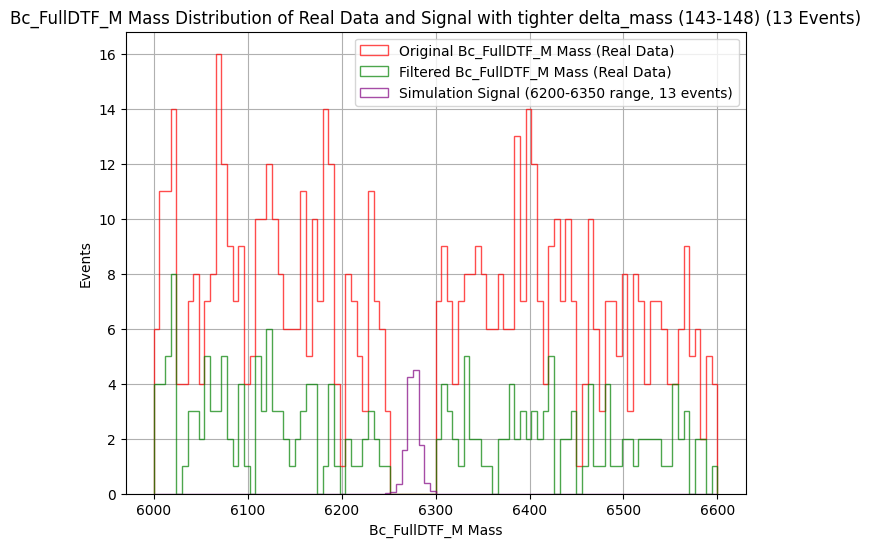

In [15]:
import numpy as np
import matplotlib.pyplot as plt

real_data_predictions = classif_list[i].predict_proba(X_real)[:, 1]
real_data_filtered = real_data[real_data_predictions > 0.8]

print(f"Not-filtered data size: {real_data.shape[0]}")
print(f"Filtered data size: {real_data_filtered.shape[0]}")

# --- Signal Shape in Range 6200-6350 from Simulation Data ---
signal_range = (simu_data['Bc_FullDTF_M'] > 6250) & (simu_data['Bc_FullDTF_M'] < 6300)
simu_signal_in_range = simu_data['Bc_FullDTF_M'][signal_range]

# --- Sample 13 events from the signal distribution ---
simu_signal_sampled = np.random.choice(simu_signal_in_range, size=13, replace=False)
scaling_factor = 13/len(simu_signal_in_range)
# --- Plot everything as histograms ---
plt.figure(figsize=(8, 6))

# Plot all Bc_FullDTF_M Mass (real data, not filtered) as a histogram
plt.hist(real_data['Bc_FullDTF_M'], range = (6000, 6600), bins=100, alpha=0.7, color='red', label="Original Bc_FullDTF_M Mass (Real Data)", histtype='step')

# Plot filtered Bc_FullDTF_M Mass (real data, filtered by classifier threshold) as a histogram
plt.hist(real_data_filtered['Bc_FullDTF_M'], range = (6000, 6600), bins=100, alpha=0.7, color='green', label="Filtered Bc_FullDTF_M Mass (Real Data)", histtype='step')

# Plot exactly 13 events sampled from the simulation signal in Bc_FullDTF_M Mass range (6200-6350)
plt.hist(simu_signal_in_range, range = (6000, 6600), bins=100, alpha=0.7, color='purple', label="Simulation Signal (6200-6350 range, 13 events)", histtype='step', weights=(np.ones_like(simu_signal_in_range) * scaling_factor))

# Labels, legend, and title
plt.xlabel("Bc_FullDTF_M Mass")
plt.ylabel("Events")
plt.title("Bc_FullDTF_M Mass Distribution of Real Data and Signal with tighter delta_mass (143-148) (13 Events)")
plt.legend()
plt.grid(True)
plt.show()


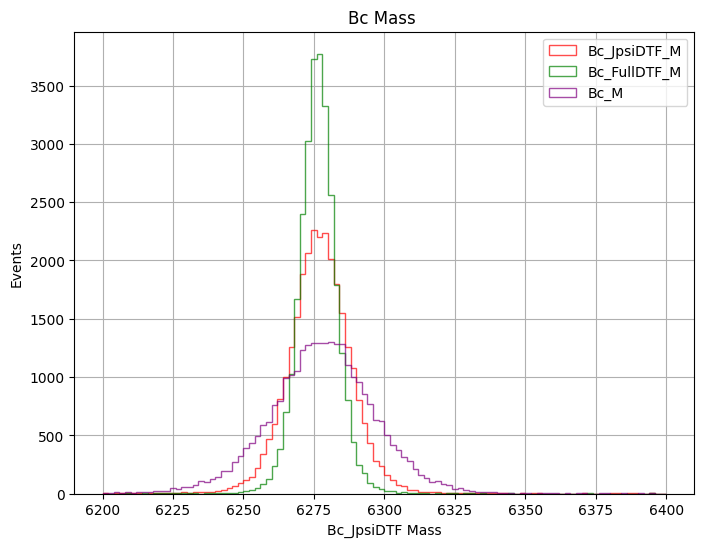

In [14]:
plt.figure(figsize=(8, 6))

# Plot all Bc_JpsiDTF Mass (simu data, not filtered) as a histogram
plt.hist(simu_data['Bc_JpsiDTF_M'], range = (6200, 6400), bins=100, alpha=0.7, color='red', label="Bc_JpsiDTF_M", histtype='step')

plt.hist(simu_data['Bc_FullDTF_M'], range = (6200, 6400), bins=100, alpha=0.7, color='green', label="Bc_FullDTF_M", histtype='step')
plt.hist(simu_data['Bc_M'], range = (6200, 6400), bins=100, alpha=0.7, color='purple', label="Bc_M", histtype='step')

# Labels, legend, and title
plt.xlabel("Bc_JpsiDTF Mass")
plt.ylabel("Events")
plt.title("Bc Mass ")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
print(np.unique(y_real, return_counts=True))


(array([0.]), array([3448]))


In [55]:
print(np.isnan(real_data_predictions).sum())  # Check for NaNs
print(np.unique(real_data_predictions))  # Check for constant values
print(f"Filtered data size: {real_data_filtered.shape[0]}")

print(f"Filtered data size: {real_data_filtered.shape[0]}")

print(f"y_real length: {len(y_real)}")
print(f"real_data_predictions length: {len(real_data_predictions)}")
fpr, tpr, thresholds = roc_curve(y_real, real_data_predictions)
if np.isnan(fpr).any() or np.isnan(tpr).any():
    print("ROC curve calculation has NaN values")


0
[0.00477423 0.00649533 0.00905637 ... 0.99469805 0.995133   0.99583507]
Filtered data size: 1698
Filtered data size: 1698
y_real length: 3448
real_data_predictions length: 3448
ROC curve calculation has NaN values


/Users/khrystina/new_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [47]:
print(X_train.columns)  # columns of the training data
print(real_data.columns)  # columns of the real_data


Index(['mp_PT', 'mm_PT', 'Bc_ENDVERTEX_CHI2', 'Bc_IPCHI2_OWNPV', 'Bc_FD_OWNPV',
       'Jpsi_FD_ORIVX', 'D0_FD_ORIVX'],
      dtype='object')
Index(['index', 'Bc_ETA', 'Bc_MINIP', 'Bc_MINIPCHI2', 'Bc_PHI',
       'Bc_ENDVERTEX_X', 'Bc_ENDVERTEX_Y', 'Bc_ENDVERTEX_Z',
       'Bc_ENDVERTEX_XERR', 'Bc_ENDVERTEX_YERR',
       ...
       'nOTClusters', 'nSPDHits', 'nMuonCoordsS0', 'nMuonCoordsS1',
       'nMuonCoordsS2', 'nMuonCoordsS3', 'nMuonCoordsS4', 'nMuonTracks', 'q2',
       'delta_mass'],
      dtype='object', length=1076)
